In [ ]:
# Import necessary libraries and modules
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense
import joblib
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

In [ ]:
df=pd.read_csv("/content/google_stock_price_full.csv")

In [ ]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,2.490664,2.591785,2.390042,2.499133,2.499133,897427216
1,2004-08-20,2.515820,2.716817,2.503118,2.697639,2.697639,458857488
2,2004-08-23,2.758411,2.826406,2.716070,2.724787,2.724787,366857939
3,2004-08-24,2.770615,2.779581,2.579581,2.611960,2.611960,306396159
4,2004-08-25,2.614201,2.689918,2.587302,2.640104,2.640104,184645512
...,...,...,...,...,...,...,...
4935,2024-03-28,152.000000,152.669998,151.330002,152.259995,152.259995,21105600
4936,2024-04-01,151.830002,157.000000,151.649994,156.500000,156.500000,24469800
4937,2024-04-02,154.750000,155.990005,153.460007,155.869995,155.869995,17598100
4938,2024-04-03,154.919998,156.550003,154.132004,156.369995,156.369995,17218400


In [ ]:
df.shape

(4940, 7)

In [ ]:
# Convert Date column to a valid Datetime format
df["Date"] = pd.to_datetime(df["Date"])

In [ ]:
df.dtypes

,0
Date,datetime64[ns]
Open,float64
High,float64
Low,float64
Close,float64
Adj Close,float64
Volume,int64


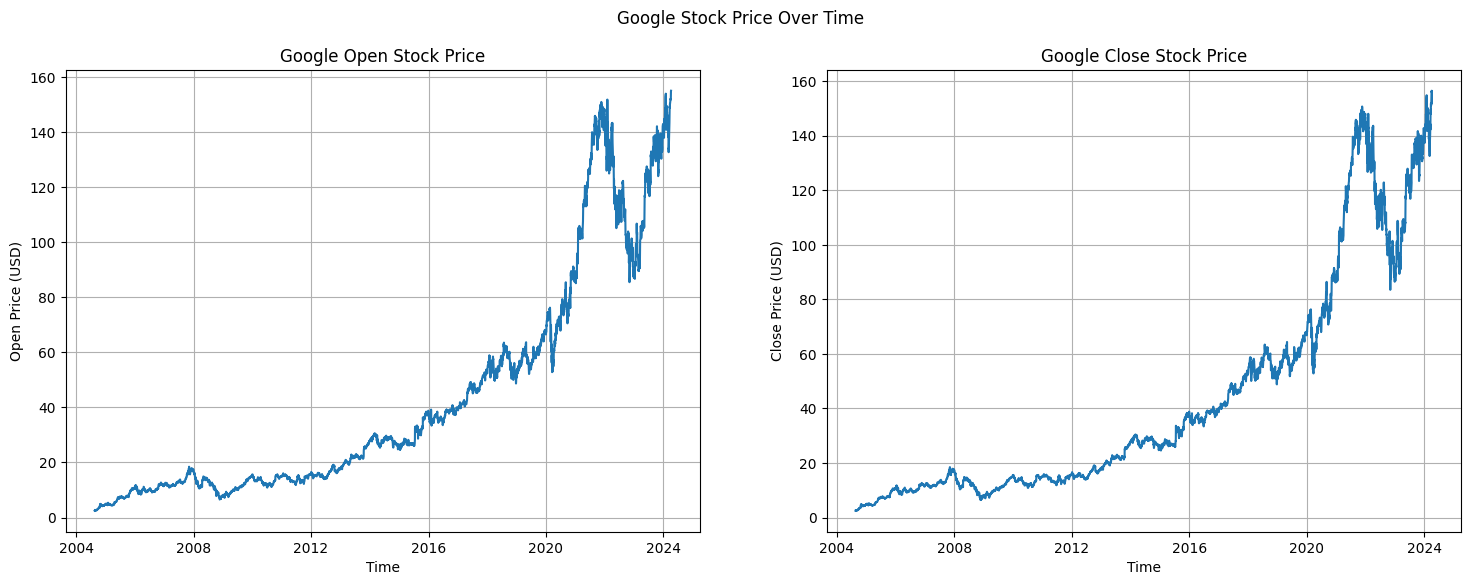

In [ ]:
# Plot Open and Close price for the whole period
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
plt.plot(df["Date"], df["Open"])
plt.xlabel("Time")
plt.ylabel("Open Price (USD)")
plt.title("Google Open Stock Price")
plt.grid()

plt.subplot(1,2,2)
plt.plot(df["Date"], df["Close"])
plt.xlabel("Time")
plt.ylabel("Close Price (USD)")
plt.title("Google Close Stock Price")
plt.grid()

plt.suptitle("Google Stock Price Over Time")
plt.show()

In [ ]:
# Select stock price records for the last five years, starting from 2019
df_5years = df[df["Date"].dt.year >= 2019]

# Check filtered data shape
df_5years.shape

(1323, 7)

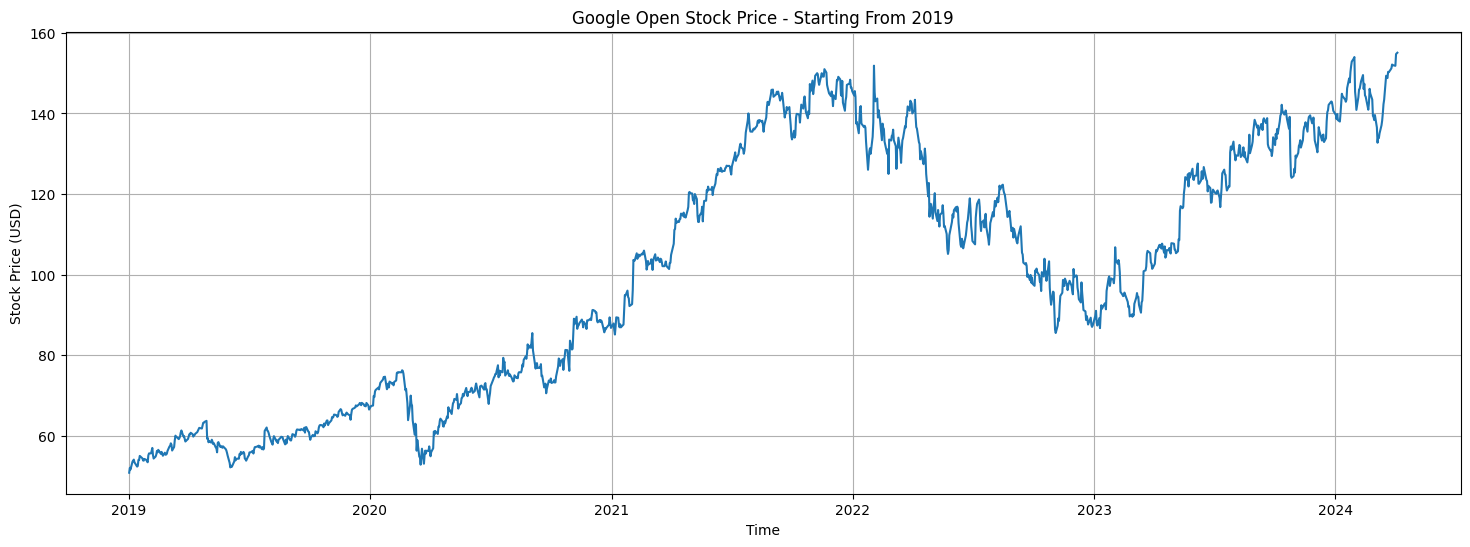

In [ ]:
# Plot Open stock price performance in the last five years
plt.figure(figsize=(18,6))
plt.plot(df_5years["Date"], df_5years["Open"])
plt.xlabel("Time")
plt.ylabel("Stock Price (USD)")
plt.title("Google Open Stock Price - Starting From 2019")
plt.grid()

***DATA PREPROCESSING***

In [ ]:
features = ["Open", "High", "Low",	"Close", "Adj Close", "Volume"]
target = "Open"

In [ ]:
# Define start and end time for each period
train_end_date = pd.to_datetime("2023-06-30")
validate_start_date = pd.to_datetime("2023-07-01")
validate_end_date = pd.to_datetime("2023-12-31")
test_start_date = pd.to_datetime("2024-01-01")
test_end_date = pd.to_datetime("2024-02-29")

# Split dataset into training, validation, and testing
data_train = df[df["Date"] <= train_end_date][features]
data_train_dates = df[df["Date"] <= train_end_date]["Date"]
data_validate = df[(df["Date"] >= validate_start_date) & (df["Date"] <= validate_end_date)][features]
data_validate_dates = df[(df["Date"] >= validate_start_date) & (df["Date"] <= validate_end_date)]["Date"]
data_test = df[(df["Date"] >= test_start_date) & (df["Date"] <= test_end_date)][features]
data_test_dates = df[(df["Date"] >= test_start_date) & (df["Date"] <= test_end_date)]["Date"]

In [ ]:
# Display a summary of each dataset
print("Training Dataset:")
print(data_train.head())
print("Validation Dataset:")
print(data_validate.head())
print("Testing Dataset:")
print(data_test.head())

Training Dataset:
       Open      High       Low     Close  Adj Close     Volume
0  2.490664  2.591785  2.390042  2.499133   2.499133  897427216
1  2.515820  2.716817  2.503118  2.697639   2.697639  458857488
2  2.758411  2.826406  2.716070  2.724787   2.724787  366857939
3  2.770615  2.779581  2.579581  2.611960   2.611960  306396159
4  2.614201  2.689918  2.587302  2.640104   2.640104  184645512
Validation Dataset:
            Open        High         Low       Close   Adj Close    Volume
4749  120.320000  121.019997  119.705002  120.559998  120.559998  13888300
4750  120.059998  123.370003  120.059998  122.629997  122.629997  17830300
4751  120.639999  121.150002  119.250000  120.930000  120.930000  17732500
4752  120.889999  121.750000  120.089996  120.139999  120.139999  20982400
4753  119.070000  119.070000  116.639999  116.870003  116.870003  32960100
Testing Dataset:
            Open        High         Low       Close   Adj Close    Volume
4875  139.600006  140.615005  137.74

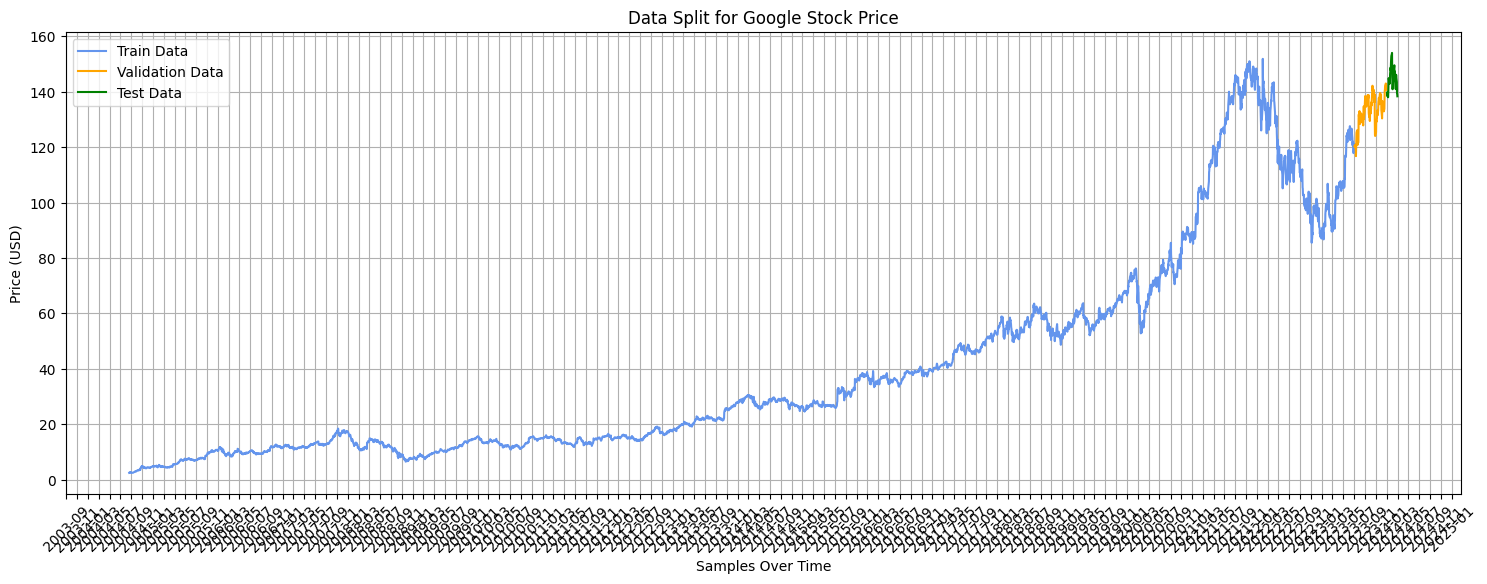

In [ ]:
# Plot stock prices for each data split
plt.figure(figsize=(18,6))
plt.plot(data_train_dates, data_train["Open"], color="cornflowerblue")
plt.plot(data_validate_dates, data_validate["Open"], color="orange")
plt.plot(data_test_dates, data_test["Open"], color="green")
plt.legend(["Train Data", "Validation Data", "Test Data"])
plt.title("Data Split for Google Stock Price")
plt.xlabel("Samples Over Time")
plt.ylabel("Price (USD)")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.xticks(rotation=45)
plt.grid()

In [ ]:
# Initialize scaler with range [0,1]
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))

# Fit and transform scaler to training set
data_train_scaled = sc.fit_transform(data_train)

# Transform validating and testing datasets
data_validate_scaled = sc.transform(data_validate)
data_test_scaled = sc.transform(data_test)

In [62]:
# Prepare scaler model name and location
scaler_model_location = "..//models//"
scaler_model_name = "google_stock_price_scaler"
scaler_model_ext = "gz"

# Store scaler model
joblib.dump(sc, scaler_model_location + scaler_model_name + "." + scaler_model_ext)

['..//models//google_stock_price_scaler.gz']

In [ ]:
# Combine dates with each corresponding dataset
data_train_scaled_final = pd.DataFrame(data_train_scaled, columns=features, index=None)
data_train_scaled_final["Date"] = data_train_dates.values

data_validate_scaled_final = pd.DataFrame(data_validate_scaled, columns=features, index=None)
data_validate_scaled_final["Date"] = data_validate_dates.values

data_test_scaled_final = pd.DataFrame(data_test_scaled, columns=features, index=None)
data_test_scaled_final["Date"] = data_test_dates.values

In [ ]:
data_file_name_train = pd.read_csv("/content/google_stock_price_processed_train.csv")
data_file_name_validate =pd.read_csv("/content/google_stock_price_processed_validate.csv")
data_file_name_test = pd.read_csv("/content/google_stock_price_processed_test.csv")

In [ ]:
# Define a method to construct the input data X and Y
def construct_lstm_data(data, sequence_size, target_attr_idx):
    """
    Construct input data (X) and target data (y) for LSTM model from a pandas DataFrame.

    Parameters:
    -----------
    data : numpy.ndarray
        Input data array of shape (n_samples, n_features).

    sequence_size : int
        Number of previous time steps to use as input features for predicting the next time step.

    target_attr_idx : int
        Index of column in `data` DataFrame that corresponds to target attribute that LSTM model will predict.

    Returns:
    --------
    data_X : numpy.ndarray
        Array of LSTM input sequences of shape (n_samples - sequence_size, sequence_size, n_features).

    data_y : numpy.ndarray
        Corresponding target values for each input sequence of shape (n_samples - sequence_size,).
    """

    # Initialize constructed data variables
    data_X = []
    data_y = []

    # Iterate over the dataset
    for i in range(sequence_size, len(data)):
        data_X.append(data[i-sequence_size:i,0:data.shape[1]])
        data_y.append(data[i,target_attr_idx])

    # Return constructed variables
    return np.array(data_X), np.array(data_y)

In [ ]:
# Define the sequence size
sequence_size = 60

# Construct training data
X_train, y_train = construct_lstm_data(data_train_scaled, sequence_size, 0)

In [ ]:
# Combine scaled datasets all together
data_all_scaled = np.concatenate([data_train_scaled, data_validate_scaled, data_test_scaled], axis=0)

# Calculate data size
train_size = len(data_train_scaled)
validate_size = len(data_validate_scaled)
test_size = len(data_test_scaled)

# Construct validation dataset
X_validate, y_validate = construct_lstm_data(data_all_scaled[train_size-sequence_size:train_size+validate_size,:], sequence_size, 0)

# Construct testing dataset
X_test, y_test = construct_lstm_data(data_all_scaled[-(test_size+sequence_size):,:], sequence_size, 0)

In [ ]:
# Check original data and data splits shapes
print(f"Full Scaled Data: {data_all_scaled.shape}")
print(f"\n Data Train Scaled: {data_train_scaled.shape}")
print(f"> Data Train X: {X_train.shape}")
print(f"> Data Train y: {y_train.shape}")

print(f"\n Data Validate Scaled: {data_validate_scaled.shape}")
print(f"> Data Validate X: {X_validate.shape}")
print(f"> Data Validate y: {y_validate.shape}")

print(f"\n Data Test Scaled: {data_test_scaled.shape}")
print(f"> Data Test X: {X_test.shape}")
print(f"> Data Test y: {y_test.shape}")

Full Scaled Data: (4916, 6)

 Data Train Scaled: (4749, 6)
> Data Train X: (4689, 60, 6)
> Data Train y: (4689,)

 Data Validate Scaled: (126, 6)
> Data Validate X: (126, 60, 6)
> Data Validate y: (126,)

 Data Test Scaled: (41, 6)
> Data Test X: (41, 60, 6)
> Data Test y: (41,)


In [ ]:
# Initializing the model
regressor = Sequential()

In [ ]:
# Add input layer
regressor.add(Input(shape=(X_train.shape[1], X_train.shape[2])))

In [ ]:
# Add first LSTM layer and dropout regularization layer
regressor.add(LSTM(units = 100, return_sequences = True))
regressor.add(Dropout(rate = 0.2))

In [ ]:
# Add second LSTM layer and dropout regularization layer
regressor.add(LSTM(units = 100, return_sequences = True))
regressor.add(Dropout(rate = 0.2))

In [ ]:
# Add third LSTM layer and dropout regularization layer
regressor.add(LSTM(units = 100, return_sequences = True))
regressor.add(Dropout(rate = 0.2))

In [ ]:
# Add forth LSTM layer and dropout regularization layer
regressor.add(LSTM(units = 100))
regressor.add(Dropout(rate = 0.2))

In [ ]:
# Add last dense layer/output layer
regressor.add(Dense(units = 1))
# Compiling the model
regressor.compile(optimizer = "adam", loss="mean_squared_error")

In [ ]:
# Create a checkpoint to monitor the validation loss and save the model with the best performance.
model_location = "..//models//"
model_name = "google_stock_price_lstm.model.keras"
best_model_checkpoint_callback = ModelCheckpoint(
    model_location + model_name,
    monitor="val_loss",
    save_best_only=True,
    mode="min",
    verbose=0)

In [54]:
# Training the model
history = regressor.fit(
    x = X_train,
    y = y_train,
    validation_data=(X_validate, y_validate),
    epochs=125,
    batch_size = 64,
    callbacks = [best_model_checkpoint_callback])

Epoch 1/125
74/74 ━━━━━━━━━━━━━━━━━━━━ 31s 420ms/step - loss: 5.9532e-04 - val_loss: 0.0010
Epoch 2/125
74/74 ━━━━━━━━━━━━━━━━━━━━ 41s 411ms/step - loss: 5.7412e-04 - val_loss: 7.7367e-04
Epoch 3/125
74/74 ━━━━━━━━━━━━━━━━━━━━ 40s 405ms/step - loss: 5.4858e-04 - val_loss: 9.0867e-04
Epoch 4/125
74/74 ━━━━━━━━━━━━━━━━━━━━ 41s 402ms/step - loss: 5.6000e-04 - val_loss: 6.2793e-04
Epoch 5/125
74/74 ━━━━━━━━━━━━━━━━━━━━ 43s 424ms/step - loss: 4.6895e-04 - val_loss: 0.0012
Epoch 6/125
74/74 ━━━━━━━━━━━━━━━━━━━━ 41s 419ms/step - loss: 4.9428e-04 - val_loss: 0.0015
Epoch 7/125
74/74 ━━━━━━━━━━━━━━━━━━━━ 40s 405ms/step - loss: 4.3420e-04 - val_loss: 6.3947e-04
Epoch 8/125
74/74 ━━━━━━━━━━━━━━━━━━━━ 41s 403ms/step - loss: 4.5413e-04 - val_loss: 5.6852e-04
Epoch 9/125
74/74 ━━━━━━━━━━━━━━━━━━━━ 41s 403ms/step - loss: 4.5155e-04 - val_loss: 0.0013
Epoch 10/125
74/74 ━━━━━━━━━━━━━━━━━━━━ 43s 427ms/step - loss: 5.0234e-04 - val_loss: 0.0011
Epoch 11/125
74/74 ━━━━━━━━━━━━━━━━━━━━ 40s 409ms/step - lo

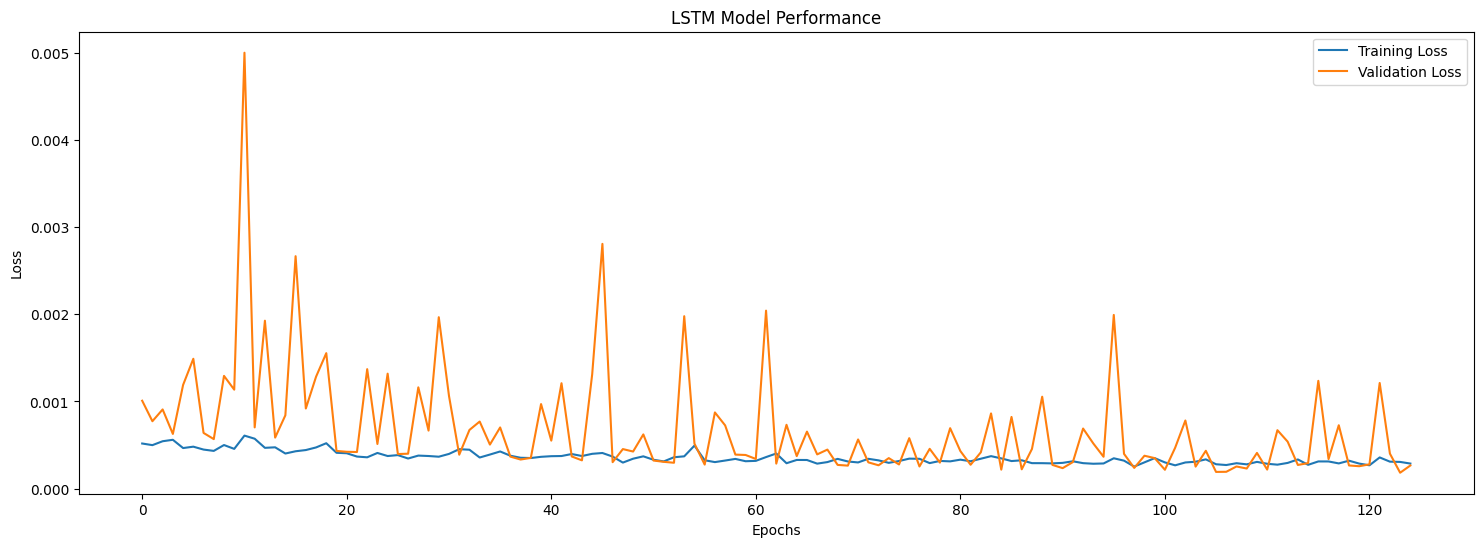

In [55]:
# Visualizing model performance during training
plt.figure(figsize=(18, 6))

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")

plt.title("LSTM Model Performance")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [59]:
model_location = "..//models//"
model_name = "google_stock_price_lstm.model.keras"

# Load the best performing model
best_model = load_model(model_location + model_name)

y_train_predict = best_model.predict(X_train)
y_validate_predict = best_model.predict(X_validate)
y_test_predict = best_model.predict(X_test)

147/147 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


In [63]:
# Prepare scaler model name and location
scaler_model_location = "..//models//"
scaler_model_name = "google_stock_price_scaler"
scaler_model_ext = "gz"

# Store the scaler model
sc = joblib.load(scaler_model_location + scaler_model_name + "." + scaler_model_ext)

In [64]:
# Restore actual distribution for predicted prices
y_train_inv = sc.inverse_transform(np.concatenate((y_train.reshape(-1,1), np.ones((len(y_train.reshape(-1,1)), 5))), axis=1))[:,0]
y_validate_inv = sc.inverse_transform(np.concatenate((y_validate.reshape(-1,1), np.ones((len(y_validate.reshape(-1,1)), 5))), axis=1))[:,0]
y_test_inv = sc.inverse_transform(np.concatenate((y_test.reshape(-1,1), np.ones((len(y_test.reshape(-1,1)), 5))), axis=1))[:,0]

y_train_predict_inv = sc.inverse_transform(np.concatenate((y_train_predict, np.ones((len(y_train_predict), 5))), axis=1))[:,0]
y_validate_predict_inv = sc.inverse_transform(np.concatenate((y_validate_predict, np.ones((len(y_validate_predict), 5))), axis=1))[:,0]
y_test_predict_inv = sc.inverse_transform(np.concatenate((y_test_predict, np.ones((len(y_test_predict), 5))), axis=1))[:,0]

In [65]:
# Define chart colors
train_actual_color = "cornflowerblue"
validate_actual_color = "orange"
test_actual_color = "green"
train_predicted_color = "lightblue"
validate_predicted_color = "peru"
test_predicted_color = "limegreen"

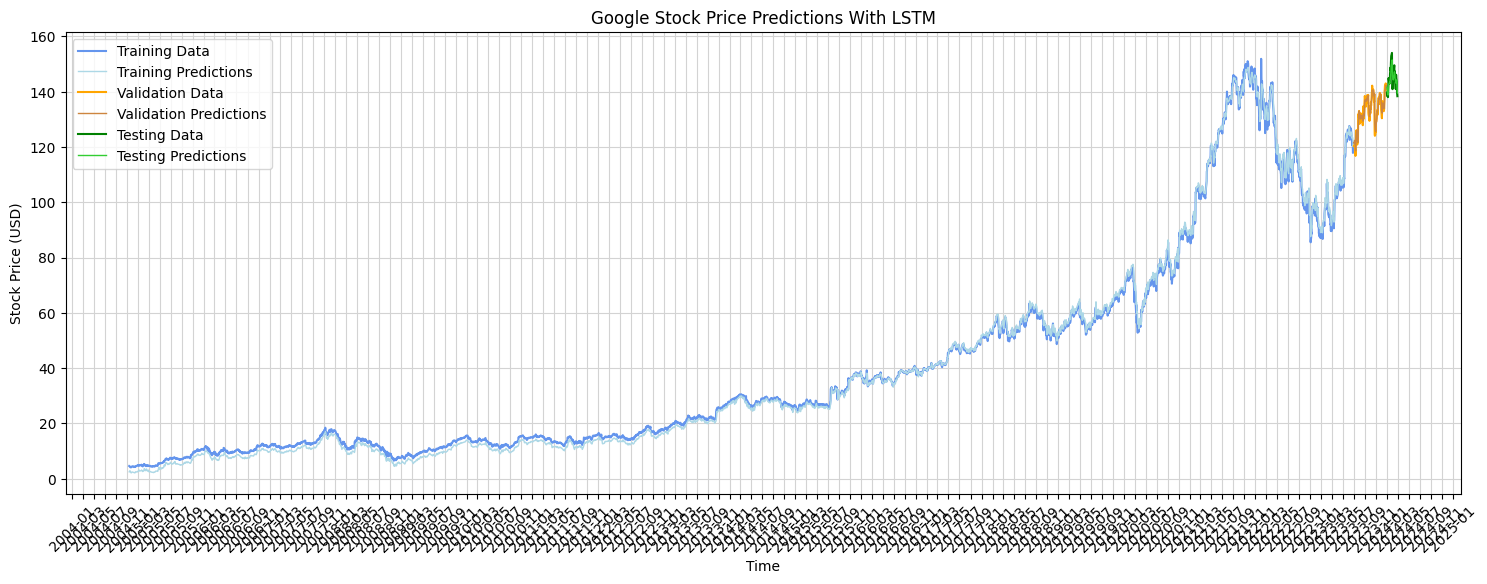

In [66]:
# Plot actual and predicted price
plt.figure(figsize=(18,6))
plt.plot(data_train_dates[sequence_size:,], y_train_inv, label="Training Data", color=train_actual_color)
plt.plot(data_train_dates[sequence_size:,], y_train_predict_inv, label="Training Predictions", linewidth=1, color=train_predicted_color)

plt.plot(data_validate_dates, y_validate_inv, label="Validation Data", color=validate_actual_color)
plt.plot(data_validate_dates, y_validate_predict_inv, label="Validation Predictions", linewidth=1, color=validate_predicted_color)

plt.plot(data_test_dates, y_test_inv, label="Testing Data", color=test_actual_color)
plt.plot(data_test_dates, y_test_predict_inv, label="Testing Predictions", linewidth=1, color=test_predicted_color)

plt.title("Google Stock Price Predictions With LSTM")
plt.xlabel("Time")
plt.ylabel("Stock Price (USD)")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.xticks(rotation=45)
plt.legend()
plt.grid(color="lightgray")

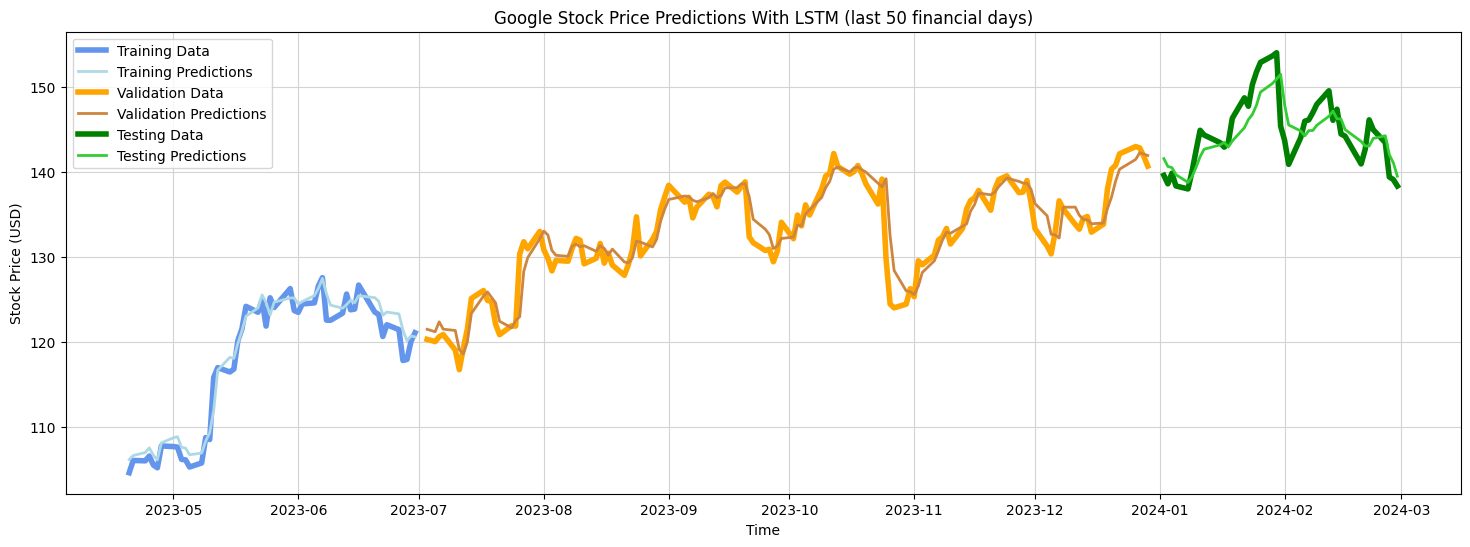

In [67]:
recent_samples = 50
plt.figure(figsize=(18,6))
plt.plot(data_train_dates[-recent_samples:,], y_train_inv[-recent_samples:,], label="Training Data", color=train_actual_color, linewidth=4)
plt.plot(data_train_dates[-recent_samples:,], y_train_predict_inv[-recent_samples:,], label="Training Predictions", linewidth=2, color=train_predicted_color)

plt.plot(data_validate_dates, y_validate_inv, label="Validation Data", color=validate_actual_color, linewidth=4)
plt.plot(data_validate_dates, y_validate_predict_inv, label="Validation Predictions", linewidth=2, color=validate_predicted_color)

plt.plot(data_test_dates, y_test_inv, label="Testing Data", color=test_actual_color, linewidth=4)
plt.plot(data_test_dates, y_test_predict_inv, label="Testing Predictions", linewidth=2, color=test_predicted_color)

plt.title("Google Stock Price Predictions With LSTM (last 50 financial days)")
plt.xlabel("Time")
plt.ylabel("Stock Price (USD)")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
# plt.xticks(rotation=45)
plt.legend()
plt.grid(color="lightgray")